In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from scipy import stats
import scipy
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Load Data

In [2]:
basics = pd.read_csv('Data/title-basics.csv',low_memory = False)
ratings = pd.read_csv('Data/title-ratings.csv', low_memory = False)
year_2001 = pd.read_csv('Data/final_tmdb_data_2001.csv.gz', low_memory = False)
year_2002 = pd.read_csv('Data/final_tmdb_data_2002.csv.gz', low_memory = False)

In [3]:
tmdb_df = pd.concat([year_2001, year_2002])
tmdb_df.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0035423,0.0,/hfeiSfWYujh6MKhtGTXyK3DD4nN.jpg,NaN,48000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 14, ...",NaN,11232.0,en,Kate & Leopold,...,76019048.0,118.0,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,"If they lived in the same century, they'd be p...",Kate & Leopold,0.0,6.331,1226.0,PG-13
2,tt0114447,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",NaN,151007.0,en,The Silent Force,...,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They left him for dead... They should have fin...,The Silent Force,0.0,5.000,3.0,NaN
3,tt0116916,0.0,/rFpHBidSlhjflmnLu7BZilyKeQR.jpg,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,73549.0,en,The Dark Mist,...,0.0,101.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Dark Mist,0.0,3.500,2.0,PG
4,tt0118589,0.0,/9NZAirJahVilTiDNCHLFcdkwkiy.jpg,NaN,22000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,10696.0,en,Glitter,...,5271666.0,104.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"In music she found her dream, her love, herself.",Glitter,0.0,4.442,130.0,PG-13


In [4]:
tmdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2637 entries, 0 to 1288
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                2637 non-null   object 
 1   adult                  2635 non-null   float64
 2   backdrop_path          1506 non-null   object 
 3   belongs_to_collection  217 non-null    object 
 4   budget                 2635 non-null   float64
 5   genres                 2635 non-null   object 
 6   homepage               212 non-null    object 
 7   id                     2635 non-null   float64
 8   original_language      2635 non-null   object 
 9   original_title         2635 non-null   object 
 10  overview               2582 non-null   object 
 11  popularity             2635 non-null   float64
 12  poster_path            2398 non-null   object 
 13  production_companies   2635 non-null   object 
 14  production_countries   2635 non-null   object 
 15  rele

In [5]:
tmdb_df = tmdb_df.dropna(subset=['certification','revenue'])

# Hypothesis Testing

# Q1: Does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?

### Hypothesis Defined

- $H_0$ (Null Hypothesis): There is no significant difference between revenue and the rating of a movie.
- $H_A$ (Alternative Hypothesis):  There is a significant difference between revenue and the rating of a movie.

###  Determine the correct test to perform.
- Type of Data? numeric
- How many groups/samples? > 2 groups
- Therefore, which test is appropriate? ANOVA

In [6]:
tmdb_df = tmdb_df[tmdb_df.revenue !=0]

In [7]:
tmdb_df['certification'].value_counts()

R        191
PG-13    139
PG        37
G         15
NR        12
Name: certification, dtype: int64

In [8]:
tmdb_df['certification'] = tmdb_df['certification'].replace({'R ': 'R',
                                                            'PG-13 ': 'PG-13'})
tmdb_df['certification'].value_counts()

R        191
PG-13    139
PG        37
G         15
NR        12
Name: certification, dtype: int64

In [9]:
# Create groups dictionary.
groups = {}
## Loop through all unique categories
for rating in tmdb_df['certification'].unique():
    ## Get series for group and rename
    data = tmdb_df.loc[tmdb_df['certification']==rating,'revenue'].copy()
    
    # save into the dictionary
    groups[rating] = data
groups.keys()

dict_keys(['PG-13', 'R', 'PG', 'NR', 'G'])

### Checking for Outliers

In [10]:
## Loop through groups dict
for rating, data in groups.items():

    ## determine if there are any outliers
    outliers = np.abs(stats.zscore(data)) > 3
    
    ## print a statement about how many outliers for which group name
    print(f"There were {outliers.sum()} outliers in the {rating} group.")

    ## Remove the outiers from data and overwrite the rating data in the dict
    data = data.loc[~outliers]
    groups[rating] = data

There were 2 outliers in the PG-13 group.
There were 3 outliers in the R group.
There were 1 outliers in the PG group.
There were 0 outliers in the NR group.
There were 1 outliers in the G group.


### Test for Normality

In [11]:
## Running normal test on each group and confirming there are >20 in each group

## Save a list with an inner list of column names
norm_results = [['group','n','pval','sig?']]


## loop through group dict
for rating, data in groups.items():
    ## calculate normaltest results
    stat, p = stats.normaltest(data)
    
    ## Append the right info into norm_resutls (as a list)
    norm_results.append([rating,len(data), p, p<.05])
    
    
## Make norm_results a dataframe (first row is columns, everything else data)
normal_results = pd.DataFrame(norm_results[1:], columns = norm_results[0])
normal_results

/usr/local/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/usr/local/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


,group,n,pval,sig?
0,PG-13,137,8.430582e-12,True
1,R,188,3.018833e-16,True
2,PG,36,2.586550e-06,True
3,NR,12,6.190481e-04,True
4,G,14,2.870226e-01,False


- We failed the assumpution for normality for G, PG, PG-13, R, and NR groups, but these groups are large enough that we can safely disregard the assumption of normality.

### Check for Equal Variance

In [12]:
## Use Levene's test for equal variance
result = stats.levene(*groups.values())
print(result)

LeveneResult(statistic=12.612885756810318, pvalue=1.1942216891056196e-09)


In [13]:
## Use an if-else to help interpret the p-value
if result.pvalue < 0.5:
    print(f'The groups do NOT have equal variance.')
else:
    print(f'the groups DO have equal variance.')

The groups do NOT have equal variance.


- We reject the null hypothesis of equal variance.
- We wanted to run ANOVA test, but will need to use Kruskal-Wallis test insead.

### Perform and Evaluate Kruskal-Wallis Test

In [14]:
## Running Krukal Test for Original Hypothesis
result = stats.kruskal(*groups.values())
print(result)
result.pvalue<.05

KruskalResult(statistic=59.466019576815825, pvalue=3.755977766504532e-12)


True

- We reject the null hypothesis and support that there is a significant difference between revenue and the rating of a movie.

<Axes: xlabel='certification', ylabel='revenue'>

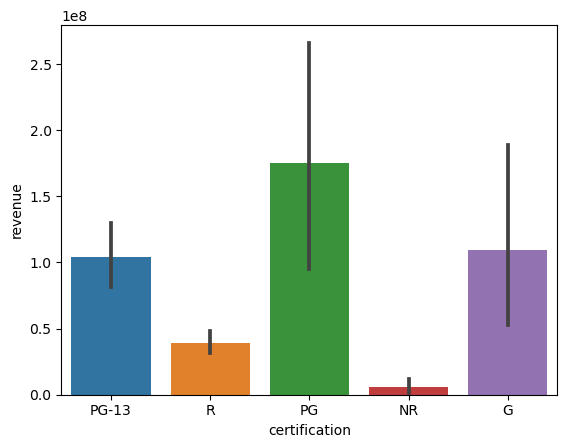

In [15]:
sns.barplot(data=tmdb_df, x='certification', y='revenue')

- PG group has the highest mean revenue and NC-17 group has the lowest mean revenue.

# Q2: Do movies that are 2.5 hours or longer earn more revenue than movies that are less than 2.5 hours?

### Hypothesis Defined

- $H_0$ (Null Hypothesis): There is no significant difference between revenue and the length of a movie.
- $H_A$ (Alternative Hypothesis):  There is a significant difference between revenue and the length of a movie.

###  Determine the correct test to perform.
- Type of Data? numeric
- How many groups/samples? 2 groups
- Therefore, which test is appropriate? 2 sample t-test

In [16]:
tmdb_df['runtime'].value_counts()

101.0    17
96.0     16
95.0     15
93.0     13
90.0     12
         ..
147.0     1
183.0     1
224.0     1
146.0     1
56.0      1
Name: runtime, Length: 84, dtype: int64

In [17]:
tmdb_df['longer_movie'] = tmdb_df['runtime'] >= 150

In [18]:
tmdb_df['longer_movie'].value_counts

<bound method IndexOpsMixin.value_counts of 1       False
4       False
9       False
10       True
12      False
        ...  
1080    False
1081    False
1130    False
1186    False
1234    False
Name: longer_movie, Length: 394, dtype: bool>

In [19]:
## save list of columns needed for each group
needed_cols = ['longer_movie', 'revenue']

In [20]:
## save longer_movie in separate variable
longer_movie_df = tmdb_df.loc[tmdb_df['longer_movie']==True, needed_cols]
longer_movie_df

,longer_movie,revenue
10,True,871368364.0
57,True,8100000.0
162,True,449220945.0
311,True,976475550.0
426,True,19000000.0
643,True,37317558.0
898,True,3786801.0
27,True,926287400.0
56,True,193772504.0
137,True,120072577.0


In [21]:
## save shorter_movie in separate variable
shorter_movie_df = tmdb_df.loc[tmdb_df['longer_movie']==False, needed_cols]
shorter_movie_df

,longer_movie,revenue
1,False,76019048.0
4,False,5271666.0
9,False,74558115.0
12,False,24690441.0
15,False,57756408.0
...,...,...
1080,False,54016370.0
1081,False,20867919.0
1130,False,3657876.0
1186,False,1831166.0


In [22]:
## Make a df just for visualization by concat the groups 
plot_df =  pd.concat([shorter_movie_df, longer_movie_df])
plot_df

,longer_movie,revenue
1,False,76019048.0
4,False,5271666.0
9,False,74558115.0
12,False,24690441.0
15,False,57756408.0
...,...,...
898,True,3786801.0
27,True,926287400.0
56,True,193772504.0
137,True,120072577.0


<Axes: xlabel='longer_movie', ylabel='revenue'>

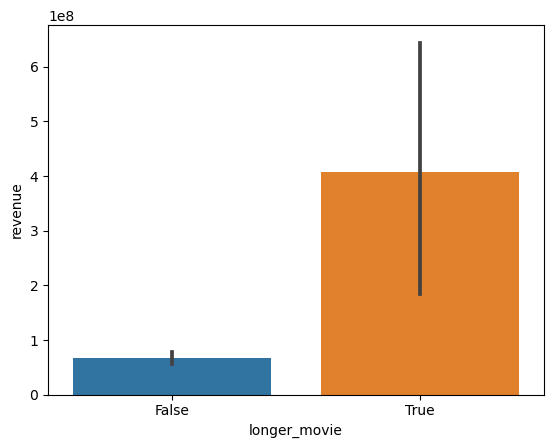

In [23]:
## visualize the groups means
sns.barplot(data=plot_df, x='longer_movie', y='revenue')

In [24]:
## Saving JUST the numeric col as final group variables
longer_movie_group = longer_movie_df['revenue']
shorter_movie_group = shorter_movie_df['revenue']
longer_movie_group

10     871368364.0
57       8100000.0
162    449220945.0
311    976475550.0
426     19000000.0
643     37317558.0
898      3786801.0
27     926287400.0
56     193772504.0
137    120072577.0
556    876688482.0
Name: revenue, dtype: float64

### Check for Outliers

In [25]:
## Check longer_movie_group for outliers
longer_movie_outliers = np.abs(stats.zscore(longer_movie_group)) > 3

## how many outliers?
longer_movie_outliers.sum()

0

In [26]:
## remove outliers from longer_movie_group
longer_movie_group = longer_movie_group.loc[~longer_movie_outliers]
longer_movie_group

10     871368364.0
57       8100000.0
162    449220945.0
311    976475550.0
426     19000000.0
643     37317558.0
898      3786801.0
27     926287400.0
56     193772504.0
137    120072577.0
556    876688482.0
Name: revenue, dtype: float64

In [27]:
## Check shorter_movie_group for outliers
shorter_movie_outliers = np.abs(stats.zscore(shorter_movie_group)) > 3

## how many outliers?
shorter_movie_outliers.sum()

10

In [28]:
## remove outliers from shorter_movie_group
shorter_movie_group = shorter_movie_group.loc[~shorter_movie_outliers]
shorter_movie_group

1       76019048.0
4        5271666.0
9       74558115.0
12      24690441.0
15      57756408.0
           ...    
1080    54016370.0
1081    20867919.0
1130     3657876.0
1186     1831166.0
1234    13107237.0
Name: revenue, Length: 373, dtype: float64

### Test for Normality

In [29]:
result = stats.normaltest(longer_movie_group)
print(result.pvalue)
result.pvalue < .05

0.046909605517271705


/usr/local/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


True

In [30]:
len(longer_movie_group)

11

In [31]:
result = stats.normaltest(shorter_movie_group)
result.pvalue < .05

True

In [32]:
len(shorter_movie_group)

373

- We fail to reject the null hypothesis that there is no statistical difference between the longer_movie_group and a normal distribution. 
- We reject the null hypothesis and conclude that there is a statistical difference between the shorter_movie_group and a normal distribution.

### Check for Equal Variance

In [33]:
## Use Levene's test for equal variance
result = stats.levene(longer_movie_group, shorter_movie_group)
print(result)

LeveneResult(statistic=158.21309446604758, pvalue=1.345126328492755e-30)


In [34]:
## Use an if-else to help interpret the p-value
if result.pvalue < 0.5:
    print(f'The groups do NOT have equal variance.')
else:
    print(f'the groups DO have equal variance.')

The groups do NOT have equal variance.


### Perform and Evaluate t-test

In [35]:
## run final hypothess test
result = stats.ttest_ind(longer_movie_group, shorter_movie_group, equal_var=False)
print(result)
result.pvalue < 0.05

Ttest_indResult(statistic=2.775535789986107, pvalue=0.019568310365833747)


True

- We reject the null hypothesis and support that there is a significant difference between revenue and the length of a movie.

In [36]:
print(f'The average revenue for longer_movie_group was {longer_movie_group.mean(): .2f}')
print(f'There average revenue for shorter_movie_group was {shorter_movie_group.mean(): .2f}')

The average revenue for longer_movie_group was  407462743.73
There average revenue for shorter_movie_group was  55354009.08


In [37]:
# create dataframe without outliers
plot_df = pd.concat([longer_movie_df.loc[~longer_movie_outliers],
                    shorter_movie_df.loc[~shorter_movie_outliers]], axis=0)
plot_df

,longer_movie,revenue
10,True,871368364.0
57,True,8100000.0
162,True,449220945.0
311,True,976475550.0
426,True,19000000.0
...,...,...
1080,False,54016370.0
1081,False,20867919.0
1130,False,3657876.0
1186,False,1831166.0


<Axes: xlabel='longer_movie', ylabel='revenue'>

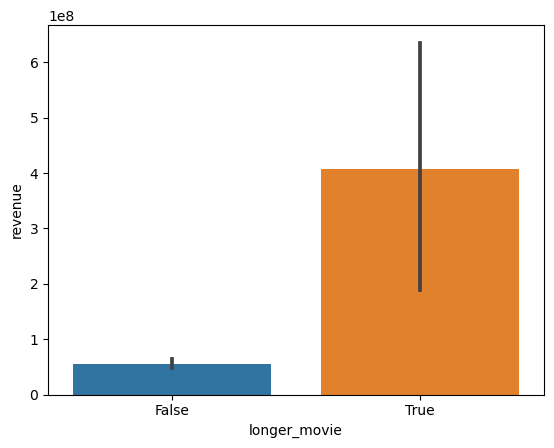

In [38]:
# vizualize means without outliers
sns.barplot(data=plot_df, x='longer_movie', y='revenue')

- There is a higher mean revenue for movies at least 2.5 hours than movies that are less than 2.5 hours.

# Q3: Do movies released in 2001 earn less revenue than movies released in 2002?

In [39]:
released_df = pd.concat([year_2001, year_2002])

In [40]:
released_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2637 entries, 0 to 1288
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                2637 non-null   object 
 1   adult                  2635 non-null   float64
 2   backdrop_path          1506 non-null   object 
 3   belongs_to_collection  217 non-null    object 
 4   budget                 2635 non-null   float64
 5   genres                 2635 non-null   object 
 6   homepage               212 non-null    object 
 7   id                     2635 non-null   float64
 8   original_language      2635 non-null   object 
 9   original_title         2635 non-null   object 
 10  overview               2582 non-null   object 
 11  popularity             2635 non-null   float64
 12  poster_path            2398 non-null   object 
 13  production_companies   2635 non-null   object 
 14  production_countries   2635 non-null   object 
 15  rele

In [41]:
released_df['release_date'] = pd.to_datetime(released_df['release_date'])

In [42]:
released_df['year'] = released_df['release_date'].dt.year
released_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2637 entries, 0 to 1288
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   imdb_id                2637 non-null   object        
 1   adult                  2635 non-null   float64       
 2   backdrop_path          1506 non-null   object        
 3   belongs_to_collection  217 non-null    object        
 4   budget                 2635 non-null   float64       
 5   genres                 2635 non-null   object        
 6   homepage               212 non-null    object        
 7   id                     2635 non-null   float64       
 8   original_language      2635 non-null   object        
 9   original_title         2635 non-null   object        
 10  overview               2582 non-null   object        
 11  popularity             2635 non-null   float64       
 12  poster_path            2398 non-null   object        
 13  pro

### Hypothesis defined

- $H_0$ (Null Hypothesis): There is no significant difference between revenue and the year a movie was released.
- $H_A$ (Alternative Hypothesis):  There is a significant difference between revenue and the year a movie was released

###  Determine the correct test to perform.
- Type of Data? numeric
- How many groups/samples? 2 groups
- Therefore, which test is appropriate? 2 sample t-test

In [43]:
released_df['year_2001'] = released_df['year'] == 2001

In [44]:
released_df = released_df.dropna(subset=['year','revenue'])

In [45]:
released_df['year_2001'].value_counts()

False    1381
True     1231
Name: year_2001, dtype: int64

In [46]:
## save list of columns needed for each group
needed_cols = ['year_2001', 'revenue']

In [47]:
## save year_2001 in separate variable
year_2001_df = released_df.loc[released_df['year_2001']==True, needed_cols]
year_2001_df

,year_2001,revenue
1,True,76019048.0
2,True,0.0
4,True,5271666.0
5,True,0.0
6,True,6297.0
...,...,...
971,True,0.0
1054,True,0.0
1235,True,0.0
1241,True,0.0


In [48]:
## save year_2002 in separate variable
year_2002_df = released_df.loc[released_df['year_2001']==False, needed_cols]
year_2002_df

,year_2001,revenue
3,False,0.0
7,False,0.0
17,False,0.0
37,False,0.0
41,False,0.0
...,...,...
1284,False,0.0
1285,False,0.0
1286,False,0.0
1287,False,0.0


<Axes: xlabel='year_2001', ylabel='revenue'>

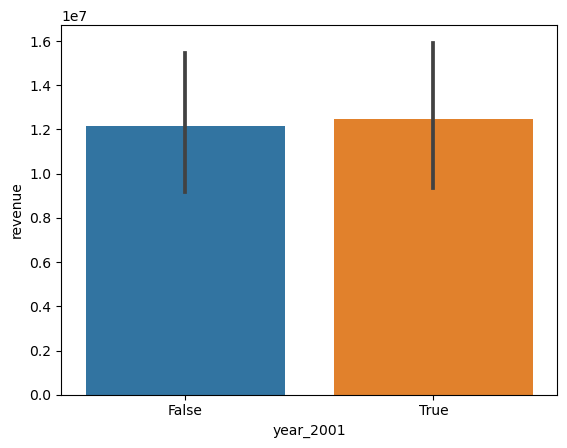

In [49]:
sns.barplot(data=released_df, x='year_2001', y='revenue')

In [50]:
## Saving JUST the numeric col as final group variables
year_2001_group = year_2001_df['revenue']
year_2002_group = year_2002_df['revenue']
year_2001_group

1       76019048.0
2              0.0
4        5271666.0
5              0.0
6           6297.0
           ...    
971            0.0
1054           0.0
1235           0.0
1241           0.0
1280           0.0
Name: revenue, Length: 1231, dtype: float64

### Check for Outliers

In [51]:
## Check year_2020_group for outliers
year_2001_outliers = np.abs(stats.zscore(year_2001_group)) > 3

## how many outliers?
year_2001_outliers.sum()

20

In [52]:
## remove outliers from year_2020_group
year_2001_group = year_2001_group.loc[~year_2001_outliers]
year_2001_group

1       76019048.0
2              0.0
4        5271666.0
5              0.0
6           6297.0
           ...    
971            0.0
1054           0.0
1235           0.0
1241           0.0
1280           0.0
Name: revenue, Length: 1211, dtype: float64

In [53]:
## Check year_2002group for outliers
year_2002_outliers = np.abs(stats.zscore(year_2002_group)) > 3

## how many outliers?
year_2002_outliers.sum()

24

In [54]:
## remove outliers from year_2002_group
year_2002_group = year_2002_group.loc[~year_2002_outliers]
year_2002_group

3       0.0
7       0.0
17      0.0
37      0.0
41      0.0
       ... 
1284    0.0
1285    0.0
1286    0.0
1287    0.0
1288    0.0
Name: revenue, Length: 1357, dtype: float64

### Test for Normality

In [55]:
result = stats.normaltest(year_2001_group)
print(result.pvalue)
result.pvalue < .05

3.663993506166757e-261


True

In [56]:
len(year_2001_group)

1211

In [57]:
result = stats.normaltest(year_2002_group)
print(result.pvalue)
result.pvalue < .05

3.4376578457507044e-303


True

In [58]:
len(year_2002_group)

1357

- We reject the null hypothesis and support that there is a statistical difference between our distribution and a normal distribution.
- Since both groups have n > 15, we can safely ignore the assumption of normality.

### Check for Equal Variance

In [59]:
result = stats.levene(year_2001_group, year_2002_group)
print(result)
print(result.pvalue<.05)

LeveneResult(statistic=0.27663486987734787, pvalue=0.5989608242560784)
False


In [60]:
## Use an if-else to help interpret the p-value
if result.pvalue < 0.5:
    print(f'The groups do NOT have equal variance.')
else:
    print(f'the groups DO have equal variance.')

the groups DO have equal variance.


- According to the documentation, the null hypothesis for the test is that both groups have equal variance. Since our pvalue is less than .05, we reject the null hypothesis.
- We will run a Welch's t-test instead by adding equal_var=False to stats.ttest_ind.

### Perform and Evaluate t-test

In [61]:
result = stats.ttest_ind(year_2001_group, year_2002_group, equal_var=False)
print(result)
result.pvalue < .05

Ttest_indResult(statistic=0.5241401658997609, pvalue=0.6002277029771868)


False

- Our Welch's T-Test return a p-value < .05 we reject the null hypothesis and support the alternative hypothesis that there is a significant difference in revenue for movies released in 2020 vs movies released in 2018.
- In order to know if they are sold significantly MORE or LESS, we look at the actual means of our final groups

In [62]:
print(f'The average revenue for year_2020_group was {year_2001_group.mean(): .2f}')
print(f'There average revenue for year_2018_group was {year_2002_group.mean(): .2f}')

The average revenue for year_2020_group was  6112637.12
There average revenue for year_2018_group was  5649150.77


In [63]:
# create dataframe without outliers
plot_df = pd.concat([year_2001_df.loc[~year_2001_outliers],
                    year_2002_df.loc[~year_2002_outliers]], axis=0)
plot_df

,year_2001,revenue
1,True,76019048.0
2,True,0.0
4,True,5271666.0
5,True,0.0
6,True,6297.0
...,...,...
1284,False,0.0
1285,False,0.0
1286,False,0.0
1287,False,0.0


<Axes: xlabel='year_2001', ylabel='revenue'>

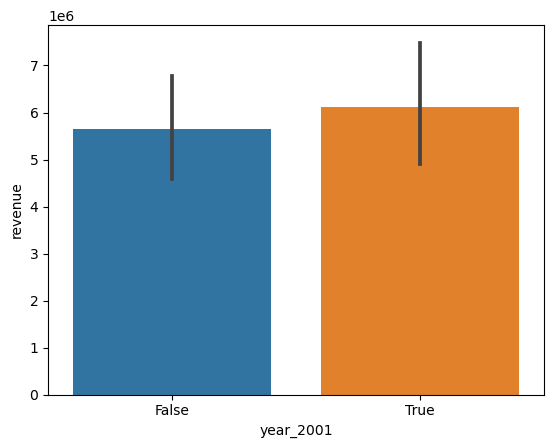

In [64]:
# vizualize means without outliers
sns.barplot(data=plot_df, x='year_2001', y='revenue')

- There is a higher mean revenue for movies released in 2001 vs movies released in 2002.